In [ ]:
import os
import random
from PIL import Image
from pathlib import Path
from timeit import default_timer as Timer
import matplotlib.pyplot as plt
import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Subset, DataLoader, ConcatDataset, Dataset
from torchinfo import summary
import onnx
from tqdm.auto import tqdm
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print(torch.__version__)
print(torchvision.__version__)

2.5.1+cu124
0.20.1+cu124


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [2]:
dataset_dir = "cifake_dataset"
train_path = dataset_dir + "train"
test_path = dataset_dir + "test"
train_path, test_path

('cifake_datasettrain', 'cifake_datasettest')

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomApply([
        transforms.GaussianBlur(kernel_size = 3, sigma = (0.1,0.3))
    ], p = 0.5),
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406],
                        std = [0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406],
                        std = [0.229, 0.224, 0.225])
])

In [ ]:
train_data = datasets.ImageFolder(root = train_path,
                                 transform = train_transform,
                                 target_transform = None)
test_data = datasets.ImageFolder(root = test_path,
                                transform = test_transform)
len(train_data), len(test_data)

(100000, 20000)

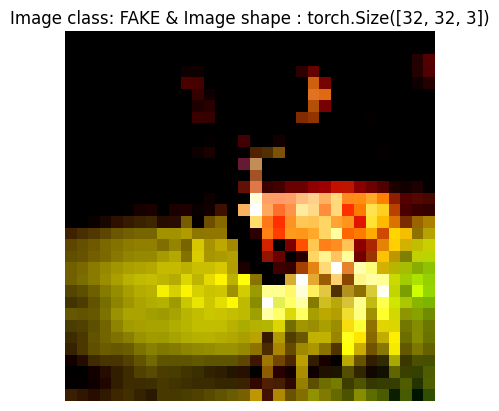

In [ ]:
class_names = ["FAKE", "REAL"]

random_idx = random.randint(0, 100000)
plt.imshow(train_data[random_idx][0].permute(1,2,0))
plt.title(f"Image class: {class_names[train_data[random_idx][1]]} & Image shape : {train_data[random_idx][0].permute(1,2,0).shape}")
plt.axis(False);

In [ ]:
BATCH_SIZE = 32
train_dataloaders = DataLoader(train_data,
                              BATCH_SIZE,
                              shuffle = True)
test_dataloaders = DataLoader(test_data,
                             BATCH_SIZE)
train_dataloaders, test_dataloaders

(<torch.utils.data.dataloader.DataLoader at 0x7d3cb8dd22d0>,
 <torch.utils.data.dataloader.DataLoader at 0x7d3dbdfa8dd0>)

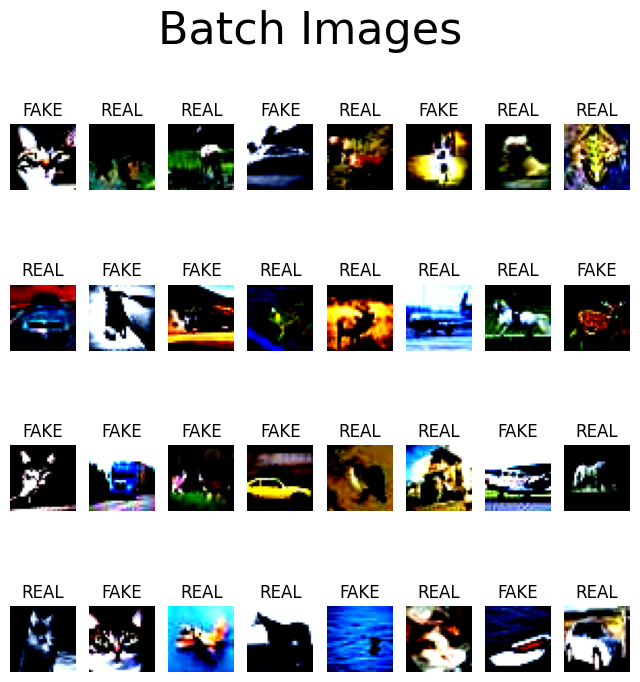

In [ ]:
fig = plt.figure(figsize = (8,8))

fig.suptitle("Batch Images", fontsize=32)
rows, columns = 4, 8
for batch_idx, (img, label) in enumerate(train_dataloaders):
    if (batch_idx < 1):
        for i in range(1, rows * columns + 1):
            fig.add_subplot(rows, columns, i)
            plt.imshow(img[i-1].permute(1,2,0))
            plt.title(class_names[int(label[i-1])], fontsize = 12)
            plt.axis(False);

In [7]:
class CNNBlock(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.input_shape = input_shape
        self.Layer = torch.nn.Sequential(
            nn.Conv2d(input_shape, hidden_units, kernel_size = (3,3)),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size = (3,3)),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Conv2d(hidden_units, output_shape, kernel_size = (5,5)),
            nn.BatchNorm2d(output_shape),
            nn.ReLU()
        )
    def get_output_shape(self, input_height, input_width):
        x = torch.randn(1, self.input_shape, input_height, input_width)
        return self.Layer(x).shape[2:]

    def forward(self, x):
        return self.Layer(x)

class PatchEmbedding(nn.Module):
    def __init__(self,
                 in_channels: int,
                 patch_size: int,
                 embedding_dim: int) -> None:
        super().__init__()
        self.in_channels = in_channels
        self.patch_size = patch_size
        self.embedding_dim = embedding_dim
        self.patcher = nn.Conv2d(in_channels= in_channels,
                                 out_channels= embedding_dim,
                                 stride= patch_size,
                                 kernel_size= patch_size,
                                 padding= 0)
        self.flatten = nn.Flatten(start_dim= 2,
                                  end_dim= 3)

    def forward(self, x):
        image_res = x.shape[-1]
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        return x_flattened.permute(0,2,1)

class MultiHeadSelfAttentionBlock(nn.Module):
    def __init__(self,
                 embedding_dim : int,
                 num_heads : int,
                 att_dropout : float):
        super().__init__()

        self.LayerNorm = nn.LayerNorm(normalized_shape= embedding_dim)

        self.MultiHeadAttention = nn.MultiheadAttention(embed_dim= embedding_dim,
                                                        num_heads= num_heads,
                                                        dropout= att_dropout,
                                                        batch_first= True)

    def forward(self, x):
        x = self.LayerNorm(x)
        attn_output, _ = self.MultiHeadAttention(query= x,
                                                 key= x,
                                                 value= x,
                                                 need_weights = False)
        return attn_output

class MultiLayerPreceptronBlock(nn.Module):
    def __init__(self,
                 embedding_dim: int,
                 mlp_size: int,
                 dropout: float):
        super().__init__()

        self.LayerNorm = nn.LayerNorm(normalized_shape= embedding_dim)

        self.MLP = nn.Sequential(
            nn.Linear(in_features= embedding_dim,
                      out_features= mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features= mlp_size,
                      out_features= embedding_dim),
            nn.Dropout(p= dropout)
        )

    def forward(self, x):
        x = self.LayerNorm(x)
        x = self.MLP(x)
        return x

class TransformerEncoder(nn.Module):
    def __init__(self,
                 embedding_dim: int,
                 num_heads: int,
                 mlp_size: int,
                 attn_dropout: float,
                 mlp_dropout: float):
        super().__init__()
        self.MSA_Block = MultiHeadSelfAttentionBlock(embedding_dim= embedding_dim,
                                               num_heads= num_heads,
                                               att_dropout= attn_dropout)
        self.MLP_Block = MultiLayerPreceptronBlock(embedding_dim= embedding_dim,
                                             mlp_size= mlp_size,
                                             dropout= mlp_dropout)

    def forward(self, x):
        x = self.MSA_Block(x) + x
        x = self.MLP_Block(x) + x
        x = self.MSA_Block(x) + x
        return x

class ViTBlock(nn.Module):
    def __init__(self,
                 image_size: int,
                 in_channels: int,
                 patch_size: int,
                 num_transformer_layers: int,
                 embedding_dim: int,
                 mlp_size: int,
                 num_heads: int,
                 attn_dropout: float,
                 mlp_dropout: float,
                 embedding_dropout: float,
                 num_classes: int = 2):
        super().__init__()

        self.num_patches = (image_size // patch_size) ** 2

        self.class_embedding = nn.Parameter(torch.randn(1, 1, embedding_dim),
                                            requires_grad= True)

        self.position_embedding = nn.Parameter(torch.randn(1, self.num_patches + 1, embedding_dim),
                                               requires_grad= True)

        self.patch_embedding = PatchEmbedding(in_channels= in_channels,
                                              patch_size= patch_size,
                                              embedding_dim= embedding_dim)

        self.embedding_dropout = nn.Dropout(p = embedding_dropout)

        self.transformerencoder = nn.Sequential(* [TransformerEncoder(embedding_dim= embedding_dim,
                                                     num_heads= num_heads,
                                                     mlp_size= mlp_size,
                                                     attn_dropout= attn_dropout,
                                                     mlp_dropout= mlp_dropout) for _ in range(num_transformer_layers)])


    def forward(self, x):
        batch_size = x.shape[0]

        class_token = self.class_embedding.expand(batch_size, -1, -1)

        x = self.patch_embedding(x)

        x = torch.cat((class_token, x), dim = 1)

        x = self.position_embedding + x

        x = self.embedding_dropout(x)

        x = self.transformerencoder(x)

        return x

class AttentionMechBlock(nn.Module):
    def __init__(self, dim, units=128):
        super().__init__()
        self.query = nn.Linear(dim, units)
        self.key = nn.Linear(dim, units)
        self.value = nn.Linear(dim, units)
        self.LayerNorm = nn.LayerNorm(normalized_shape= units)

    def forward(self, x):
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)
        attn = torch.softmax(Q @ K.transpose(1,2) / (x.size(-1)**0.5), dim=-1)
        return self.LayerNorm((attn @ V).mean(dim=1))

class HybridModel(nn.Module):

    def __init__(self,
                 image_size: int,
                 in_channels: int,
                 hidden_units: int,
                 output_shape: int,
                 patch_size: int,
                 num_transformer_layers: int,
                 embedding_dim: int,
                 mlp_size: int,
                 num_heads: int,
                 attn_dropout: float,
                 mlp_dropout: float,
                 embedding_dropout: float,
                 units: int = 128,
                 num_classes: int = 2):
        super().__init__()
        self.CNNBlock = CNNBlock(input_shape= 3,
                                 hidden_units= hidden_units,
                                 output_shape= output_shape)
        self.cnn_output_height, self.cnn_output_width = self.CNNBlock.get_output_shape(image_size, image_size)
        self.ViTBlock = ViTBlock(image_size= self.cnn_output_height,
                                 in_channels= in_channels,
                                 patch_size= patch_size,
                                 num_transformer_layers= num_transformer_layers,
                                 embedding_dim= embedding_dim,
                                 mlp_size= mlp_size,
                                 num_heads= num_heads,
                                 attn_dropout= attn_dropout,
                                 mlp_dropout= mlp_dropout,
                                 embedding_dropout= embedding_dropout,
                                 num_classes= num_classes)
        self.AttentionMechBlock = AttentionMechBlock(dim= embedding_dim,
                                                     units= units)
        self.classifier = torch.nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p = mlp_dropout),
            nn.Linear(in_features= units,
                      out_features= num_classes)
        )

    def forward(self, x):
        x = self.CNNBlock(x)
        x = self.ViTBlock(x)
        x = self.AttentionMechBlock(x)
        x = self.classifier(x)
        return x

In [4]:
pip install torchinfo

In [ ]:
Hybrid_Model = HybridModel(image_size = 32,
                          in_channels = 64,
                          hidden_units = 32,
                          output_shape = 64,
                          patch_size = 5,
                          num_transformer_layers = 5,
                          embedding_dim = 256,
                          mlp_size = 2048,
                          num_heads = 128,
                          attn_dropout = 0.1,
                          mlp_dropout = 0,
                          embedding_dropout = 0,
                          units = 128,
                          num_classes = 2).to(device)
Hybrid_Model

HybridModel(
  (CNNBlock): CNNBlock(
    (Layer): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU()
    )
  )
  (ViTBlock): ViTBlock(
    (patch_embedding): PatchEmbedding(
      (patcher): Conv2d(64, 256, kernel_size=(5, 5), stride=(5, 5))
      (flatten): Flatten(start_dim=2, end_dim=3)
    )
    (embedding_dropout): Dropout(p=0, inplace=False)
    (transformerencoder): Sequential(
      (0): TransformerEncoder(
        (MSA_Block): MultiHeadSelfAttentionBlock(
          (LayerNorm): LayerNorm((256,), eps=1e-05, elementwi

In [ ]:
import torchinfo
torchinfo.summary(model = Hybrid_Model,
                 input_size = (32,3,32,32),
                 col_names = ["input_size", "output_size", "num_params", "trainable"])

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Trainable
HybridModel                                             [32, 3, 32, 32]           [32, 2]                   --                        True
├─CNNBlock: 1-1                                         [32, 3, 32, 32]           [32, 64, 24, 24]          --                        True
│    └─Sequential: 2-1                                  [32, 3, 32, 32]           [32, 64, 24, 24]          --                        True
│    │    └─Conv2d: 3-1                                 [32, 3, 32, 32]           [32, 32, 30, 30]          896                       True
│    │    └─BatchNorm2d: 3-2                            [32, 32, 30, 30]          [32, 32, 30, 30]          64                        True
│    │    └─ReLU: 3-3                                   [32, 32, 30, 30]          [32, 32, 30, 30]          --                        --
│    │    └─Conv2d: 3-4 

In [ ]:
optimizer = torch.optim.Adam(Hybrid_Model.parameters(), lr = 0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer = optimizer,
    mode = "min",
    factor = 0.5,
    patience = 5,
    verbose = True
)
lrs = []
loss_func = torch.nn.CrossEntropyLoss()

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
import cv2
import numpy as np
import torch

def extract_hog_features(image):
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    fd, _ = hog(image_gray, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    return fd

def extract_lbp_features(image):
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(image_gray, P=8, R=1, method='uniform')
    return lbp.ravel()

def extract_color_moments(image):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    moments = []
    for i in range(3):
        channel = image_rgb[:, :, i]
        mean = np.mean(channel)
        std = np.std(channel)
        skew = np.mean((channel - mean) ** 3) / (std ** 3) if std != 0 else 0
        moments.extend([mean, std, skew])
    return moments

class CustomImageFolder(ImageFolder):
    def __getitem__(self, index):
        img_path, label = self.imgs[index]
        pil_img = self.loader(img_path)
        img_tensor = self.transform(pil_img)

        image = cv2.imread(img_path)
        if image is None:
            dummy_hog = extract_hog_features(np.zeros((224, 224, 3), dtype=np.uint8))
            dummy_lbp = extract_lbp_features(np.zeros((224, 224, 3), dtype=np.uint8))
            dummy_color = extract_color_moments(np.zeros((224, 224, 3), dtype=np.uint8))

            hog_f = np.zeros_like(dummy_hog)
            lbp_f = np.zeros_like(dummy_lbp)
            color_f = np.zeros_like(dummy_color)
        else:
            hog_f = extract_hog_features(image)
            lbp_f = extract_lbp_features(image)
            color_f = extract_color_moments(image)

        handcrafted = np.concatenate([hog_f, lbp_f, color_f])
        handcrafted = torch.tensor(handcrafted, dtype=torch.float32)

        return img_tensor, handcrafted, label


train_dataset = CustomImageFolder(root=os.path.join(BASE_DIR, "train"), transform=transform)
val_dataset = CustomImageFolder(root=os.path.join(BASE_DIR, "test"), transform=transform)
test_dataset = CustomImageFolder(root=os.path.join(BASE_DIR, "test"), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

_, sample_handcrafted, _ = next(iter(train_loader))
handcrafted_dim = sample_handcrafted.shape[1]

print(f"Actual handcrafted dimension from DataLoader: {handcrafted_dim}")

# Training loop
epochs = 10
results = {
    "train loss" : [],
    "train accuracy": [],
    "test loss" : [],
    "test accuracy" : []
}

for epoch in tqdm(range(epochs)):

    Hybrid_Model.train()
    train_loss, train_acc = 0,0
    y_train_actual = []
    y_train_predicted = []

    for batch_idx, (x, y, handcrafted) in enumerate(train_loader):
        x, y, handcrafted = x.to(device), y.to(device), handcrafted.to(device)
        y_pred = Hybrid_Model(x, handcrafted)
        loss = loss_func(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_class_pred = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_class_pred == y).sum().item() / len(y_pred)

        y_train_actual.extend(y.cpu().numpy())
        y_train_predicted.extend(y_class_pred.cpu().numpy())

    train_loss /= len(train_loader)
    train_acc /= len(train_loader)

    Hybrid_Model.eval()
    test_loss, test_acc = 0,0
    y_test_actual = []
    y_test_predicted = []

    with torch.inference_mode():
        for batch_idx, (x, y, handcrafted) in enumerate(test_loader):
            x, y, handcrafted = x.to(device), y.to(device), handcrafted.to(device)
            y_pred = Hybrid_Model(x, handcrafted)
            loss = loss_func(y_pred, y)
            test_loss += loss.item()

            y_class_pred = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            test_acc += (y_class_pred == y).sum().item() / len(y_pred)

            y_test_predicted.extend(y_class_pred.cpu().numpy())
            y_test_actual.extend(y.cpu().numpy())

        test_loss /= len(test_loader)
        test_acc /= len(test_loader)

        curr_lr = optimizer.param_groups[0]["lr"]
        lrs.append(curr_lr)
        scheduler.step(test_loss)

    results["train loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
    results["train accuracy"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
    results["test loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
    results["test accuracy"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    print(f"Epoch {epoch + 1}/{epochs} & LR {curr_lr}| train loss :{train_loss:.4f} | train accuracy :{train_acc:.4f} | test loss :{test_loss:.4f} | test accuracy :{test_acc:.4f}")

print("Model Training Completed")


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10 & LR 0.0001| train loss :0.3182 | train accuracy :0.8638 | test loss :0.2665 | test accuracy :0.8921
Epoch 2/10 & LR 0.0001| train loss :0.2260 | train accuracy :0.9097 | test loss :0.2077 | test accuracy :0.9159
Epoch 3/10 & LR 0.0001| train loss :0.1908 | train accuracy :0.9242 | test loss :0.1715 | test accuracy :0.9332
Epoch 4/10 & LR 0.0001| train loss :0.1686 | train accuracy :0.9341 | test loss :0.1621 | test accuracy :0.9375
Epoch 5/10 & LR 0.0001| train loss :0.1485 | train accuracy :0.9417 | test loss :0.1518 | test accuracy :0.9407
Epoch 6/10 & LR 0.0001| train loss :0.1297 | train accuracy :0.9501 | test loss :0.1575 | test accuracy :0.9407
Epoch 7/10 & LR 0.0001| train loss :0.1146 | train accuracy :0.9558 | test loss :0.1529 | test accuracy :0.9407
Epoch 8/10 & LR 0.0001| train loss :0.0982 | train accuracy :0.9628 | test loss :0.1929 | test accuracy :0.9288
Epoch 9/10 & LR 0.0001| train loss :0.0866 | train accuracy :0.9675 | test loss :0.1724 | test accuracy 

In [ ]:
classification_report(y_train_actual, y_train_predicted)

'              precision    recall  f1-score   support\n\n           0       0.97      0.97      0.97     50000\n           1       0.97      0.97      0.97     50000\n\n    accuracy                           0.97    100000\n   macro avg       0.97      0.97      0.97    100000\nweighted avg       0.97      0.97      0.97    100000\n'

In [ ]:
classification_report(y_test_actual, y_test_predicted)

'              precision    recall  f1-score   support\n\n           0       0.94      0.95      0.94     10000\n           1       0.95      0.94      0.94     10000\n\n    accuracy                           0.94     20000\n   macro avg       0.94      0.94      0.94     20000\nweighted avg       0.94      0.94      0.94     20000\n'

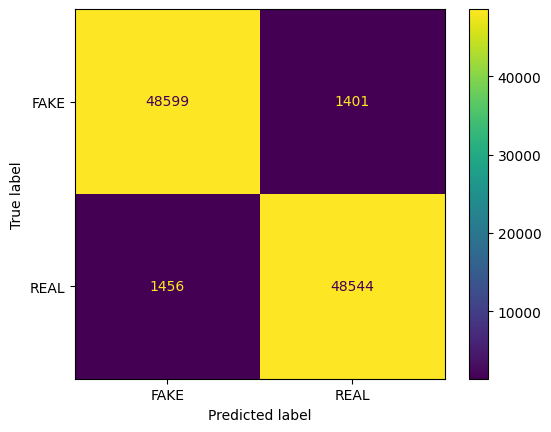

In [ ]:
cm = confusion_matrix(y_train_actual, y_train_predicted)
disp = ConfusionMatrixDisplay(cm, display_labels = class_names)
disp.plot();

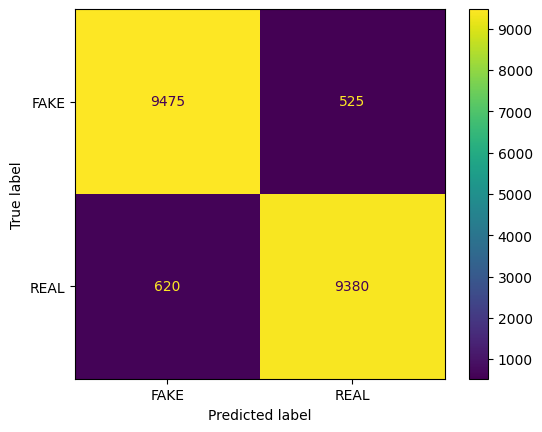

In [ ]:
cm = confusion_matrix(y_test_actual, y_test_predicted)
disp = ConfusionMatrixDisplay(cm, display_labels = class_names)
disp.plot();

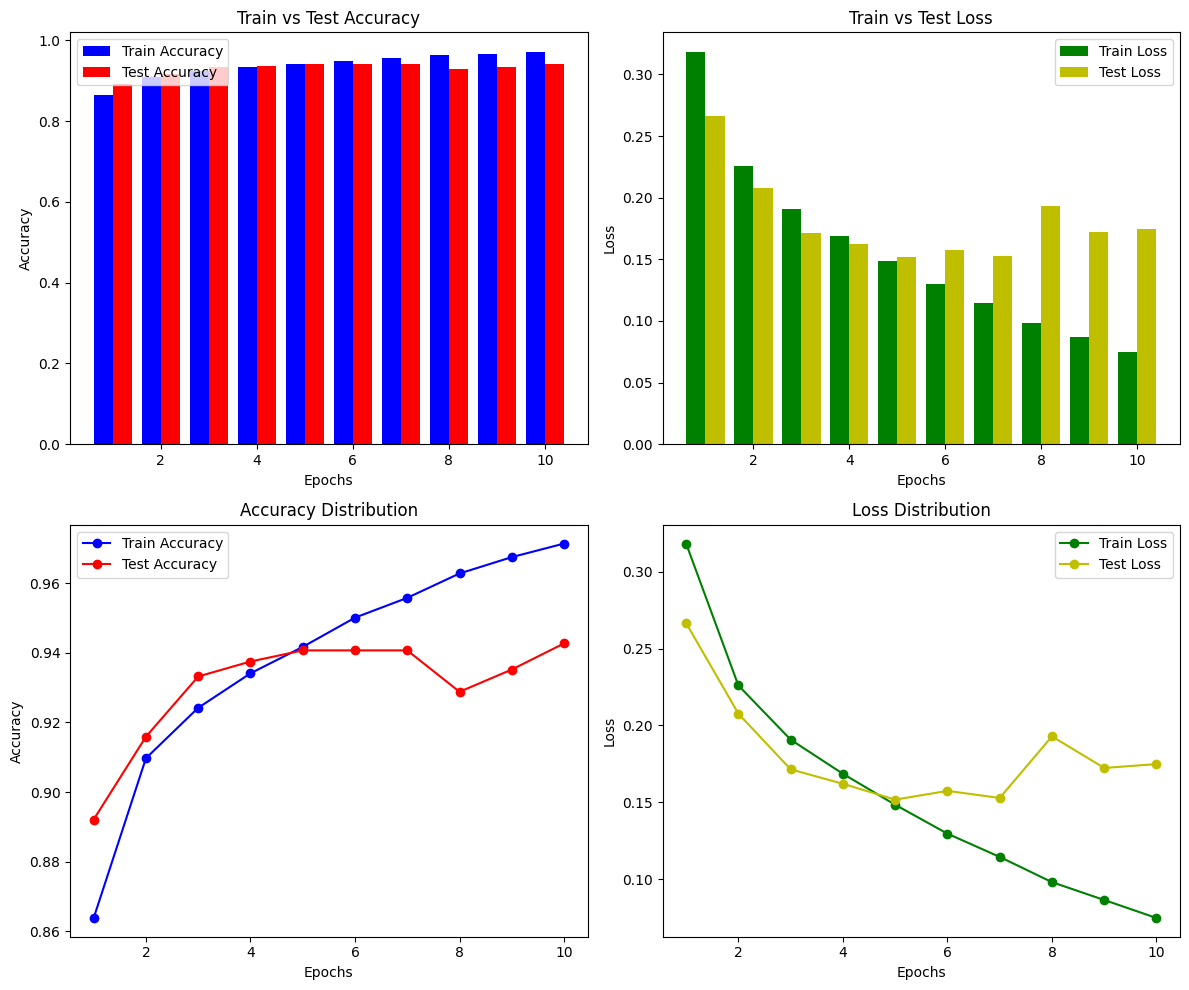

In [8]:
import matplotlib.pyplot as plt
import numpy as np

epochs = np.arange(1, 11)
train_loss = [0.3182, 0.2260, 0.1908, 0.1686, 0.1485, 0.1297, 0.1146, 0.0982, 0.0866, 0.0749]
train_accuracy = [0.8638, 0.9097, 0.9242, 0.9341, 0.9417, 0.9501, 0.9558, 0.9628, 0.9675, 0.9714]
test_loss = [0.2665, 0.2077, 0.1715, 0.1621, 0.1518, 0.1575, 0.1529, 0.1929, 0.1724, 0.1749]
test_accuracy = [0.8921, 0.9159, 0.9332, 0.9375, 0.9407, 0.9407, 0.9407, 0.9288, 0.9352, 0.9427]

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

axs[0, 0].bar(epochs - 0.2, train_accuracy, 0.4, label='Train Accuracy', color='b')
axs[0, 0].bar(epochs + 0.2, test_accuracy, 0.4, label='Test Accuracy', color='r')
axs[0, 0].set_title('Train vs Test Accuracy')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].legend()

axs[0, 1].bar(epochs - 0.2, train_loss, 0.4, label='Train Loss', color='g')
axs[0, 1].bar(epochs + 0.2, test_loss, 0.4, label='Test Loss', color='y')
axs[0, 1].set_title('Train vs Test Loss')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].legend()

axs[1, 0].plot(epochs, train_accuracy, label='Train Accuracy', color='b', marker='o')
axs[1, 0].plot(epochs, test_accuracy, label='Test Accuracy', color='r', marker='o')
axs[1, 0].set_title('Accuracy Distribution')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Accuracy')
axs[1, 0].legend()

axs[1, 1].plot(epochs, train_loss, label='Train Loss', color='g', marker='o')
axs[1, 1].plot(epochs, test_loss, label='Test Loss', color='y', marker='o')
axs[1, 1].set_title('Loss Distribution')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Loss')
axs[1, 1].legend()

plt.tight_layout()
plt.show()


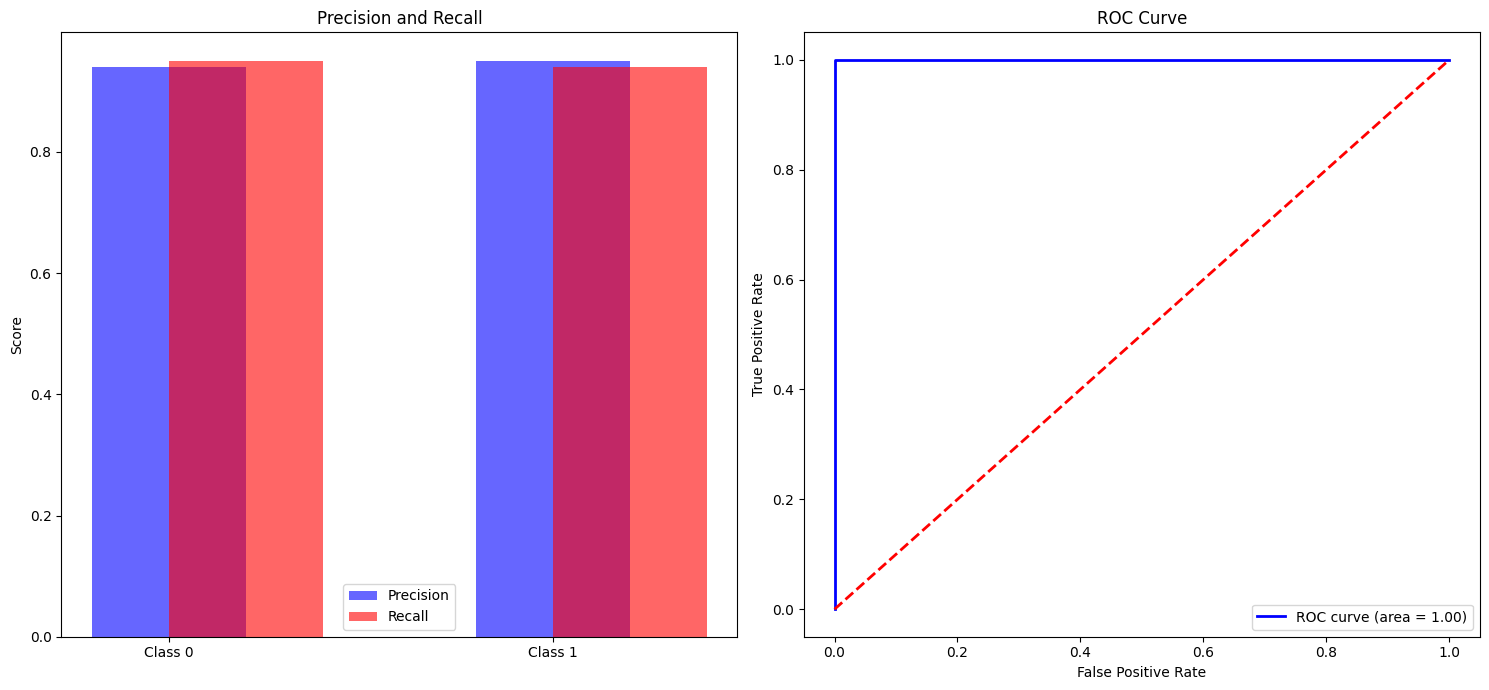

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


precision = [0.94, 0.95]
recall = [0.95, 0.94]
f1_score = [0.94, 0.94]
support = [10000, 10000]


accuracy = 0.94


y_true = [0]*10000 + [1]*10000
y_scores = [0.94]*10000 + [0.95]*10000

fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

fig, axs = plt.subplots(1, 2, figsize=(15, 7))

axs[0].bar(['Class 0', 'Class 1'], precision, width=0.4, align='center', label='Precision', color='b', alpha=0.6)
axs[0].bar(['Class 0', 'Class 1'], recall, width=0.4, align='edge', label='Recall', color='r', alpha=0.6)
axs[0].set_title('Precision and Recall')
axs[0].set_ylabel('Score')
axs[0].legend()

axs[1].plot(fpr, tpr, color='b', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
axs[1].plot([0, 1], [0, 1], color='r', lw=2, linestyle='--')
axs[1].set_title('ROC Curve')
axs[1].set_xlabel('False Positive Rate')
axs[1].set_ylabel('True Positive Rate')
axs[1].legend(loc='lower right')


plt.tight_layout()
plt.show()


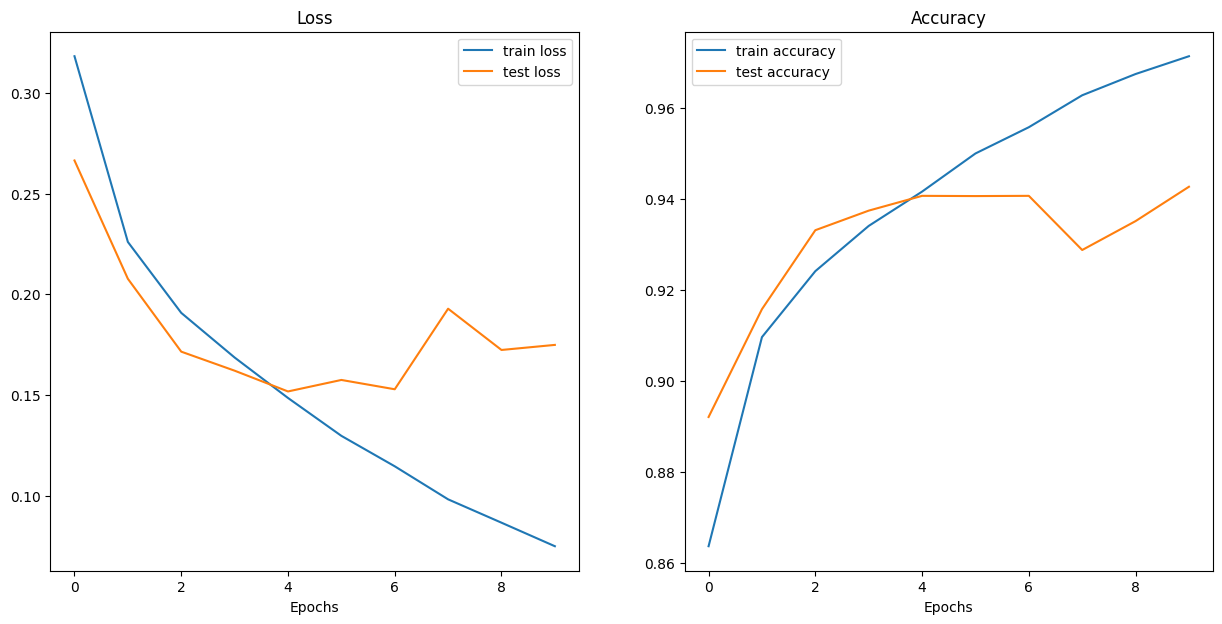

In [ ]:
epochs = range(len(results["train loss"]))
plt.figure(figsize = (15,7))
plt.subplot(1, 2, 1)
plt.plot(epochs, results["train loss"], label = "train loss")
plt.plot(epochs, results["test loss"], label = "test loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, results["train accuracy"], label = "train accuracy")
plt.plot(epochs, results["test accuracy"], label = "test accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.legend()

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import timm
import random
import numpy as np
import cv2
from skimage.feature import hog, local_binary_pattern
from skimage import color

BASE_DIR = "cifakedataset"
BATCH_SIZE = 32
EPOCHS = 15
NUM_CLASSES = 2
IMG_SIZE = 224
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

def extract_hog_features(image):
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    fd, hog_image = hog(image_gray, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    return fd

def extract_lbp_features(image):
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(image_gray, P=8, R=1, method='uniform')
    return lbp.ravel()

def extract_color_moments(image):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    moments = []
    for i in range(3):
        channel = image_rgb[:, :, i]
        mean = np.mean(channel)
        std = np.std(channel)

        skew = np.mean((channel - mean) ** 3) / (std ** 3) if std != 0 else 0
        moments.extend([mean, std, skew])
    return moments


class CustomImageFolder(ImageFolder):
    def __getitem__(self, index):
        img_path, label = self.imgs[index]
        pil_img = self.loader(img_path)
        img_tensor = self.transform(pil_img)

        image = cv2.imread(img_path)
        if image is None:

            dummy_hog = extract_hog_features(np.zeros((224, 224, 3), dtype=np.uint8))
            dummy_lbp = extract_lbp_features(np.zeros((224, 224, 3), dtype=np.uint8))
            dummy_color = extract_color_moments(np.zeros((224, 224, 3), dtype=np.uint8))

            hog_f = np.zeros_like(dummy_hog)
            lbp_f = np.zeros_like(dummy_lbp)
            color_f = np.zeros_like(dummy_color)
        else:
            hog_f = extract_hog_features(image)
            lbp_f = extract_lbp_features(image)
            color_f = extract_color_moments(image)

        handcrafted = np.concatenate([hog_f, lbp_f, color_f])
        handcrafted = torch.tensor(handcrafted, dtype=torch.float32)

        return img_tensor, handcrafted, label


train_dataset = CustomImageFolder(root=os.path.join(BASE_DIR, "train"), transform=transform)
val_dataset = CustomImageFolder(root=os.path.join(BASE_DIR, "test"), transform=transform)
test_dataset = CustomImageFolder(root=os.path.join(BASE_DIR, "test"), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

_, sample_handcrafted, _ = next(iter(train_loader))
handcrafted_dim = sample_handcrafted.shape[1]

print(f"Actual handcrafted dimension from DataLoader: {handcrafted_dim}")

class CNNViT(nn.Module):
    def __init__(self, num_classes=2, handcrafted_dim=0):
        super(CNNViT, self).__init__()
        self.cnn = models.resnet18(pretrained=True)
        self.cnn = nn.Sequential(*list(self.cnn.children())[:-2])
        self.vit = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=0)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        cnn_out_dim = 512
        vit_out_dim = self.vit.num_features


        print(f"CNN output dim: {cnn_out_dim}")
        print(f"ViT output dim: {vit_out_dim}")
        print(f"Handcrafted features dim: {handcrafted_dim}")

        total_feature_dim = cnn_out_dim + vit_out_dim + handcrafted_dim
        print(f"Total feature dim: {total_feature_dim}")

        self.fc = nn.Sequential(
            nn.Linear(total_feature_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x, handcrafted=None):

        cnn_feat = self.cnn(x)
        cnn_feat = self.avgpool(cnn_feat)
        cnn_feat = cnn_feat.view(cnn_feat.size(0), -1)


        vit_feat = self.vit(x)

        if handcrafted is not None:
            combined = torch.cat((cnn_feat, vit_feat, handcrafted), dim=1)
        else:
            combined = torch.cat((cnn_feat, vit_feat), dim=1)

        return self.fc(combined)


def evaluate(loader, model):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, handcrafted, labels in loader:
            imgs, handcrafted, labels = imgs.to(DEVICE), handcrafted.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs, handcrafted)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='weighted')
    rec = recall_score(all_labels, all_labels, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    return acc, prec, rec, f1

def boa_optimize(model_class, train_loader, val_loader, population_size=5, iterations=5):
    lb, ub = 1e-6, 1e-3


    population = np.random.uniform(lb, ub, population_size)
    fitness = np.zeros(population_size)

    for i in range(population_size):
        lr = population[i]

        model = model_class(num_classes=NUM_CLASSES, handcrafted_dim=handcrafted_dim).to(DEVICE)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()


        model.train()
        imgs, handcrafted, labels = next(iter(train_loader))
        imgs, handcrafted, labels = imgs.to(DEVICE), handcrafted.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs, handcrafted)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, _, _, f1 = evaluate(val_loader, model)
        fitness[i] = f1

    best_lr = population[np.argmax(fitness)]
    best_f1 = np.max(fitness)


    for t in range(iterations):
        fmin = np.min(fitness)
        fmax = np.max(fitness)

        for i in range(population_size):
            r = np.random.rand()
            power_exponent = 0.5
            a = 0.1

            fragrance = a * (fitness[i]**power_exponent)

            if r < 0.8:
                j = np.argmax(fitness)
                population[i] = population[i] + fragrance * (fitness[j] - fitness[i]) * np.random.rand()
            else:
                eps = np.random.uniform(-1, 1)
                k = np.random.randint(population_size)
                l = np.random.randint(population_size)
                population[i] = population[i] + eps * (fitness[k] - fitness[l]) * fragrance


            population[i] = np.clip(population[i], lb, ub)


            lr = population[i]

            model = model_class(num_classes=NUM_CLASSES, handcrafted_dim=handcrafted_dim).to(DEVICE)
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            criterion = nn.CrossEntropyLoss()
            imgs, handcrafted, labels = next(iter(train_loader))
            imgs, handcrafted, labels = imgs.to(DEVICE), handcrafted.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(imgs, handcrafted)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, _, _, f1 = evaluate(val_loader, model)
            fitness[i] = f1

        if np.max(fitness) > best_f1:
            best_f1 = np.max(fitness)
            best_lr = population[np.argmax(fitness)]

    return best_lr


print("Starting BOA for learning rate tuning...")
best_lr = boa_optimize(CNNViT, train_loader, val_loader)
print(f"\ud83d\udccc Best LR from BOA: {best_lr:.8f}")


model = CNNViT(num_classes=NUM_CLASSES, handcrafted_dim=handcrafted_dim).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=best_lr)
criterion = nn.CrossEntropyLoss()

for epoch in range(EPOCHS):
    model.train()
    all_preds, all_labels = [], []
    epoch_loss = 0
    for imgs, handcrafted, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        imgs, handcrafted, labels = imgs.to(DEVICE), handcrafted.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs, handcrafted)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        all_preds.extend(outputs.argmax(dim=1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    train_acc = accuracy_score(all_labels, all_preds)
    val_acc, val_prec, val_rec, val_f1 = evaluate(val_loader, model)

    print(f" Epoch {epoch+1} | Loss: {epoch_loss:.4f} | Train Acc: {train_acc*100:.2f}% | "
          f"Val Acc: {val_acc*100:.2f}% | Precision: {val_prec:.2f} | Recall: {val_rec:.2f} | F1: {val_f1:.2f}")


test_acc, test_prec, test_rec, test_f1 = evaluate(test_loader, model)
print(f"\n Final Test Accuracy: {test_acc*100:.2f}% | Precision: {test_prec:.2f} | Recall: {test_rec:.2f} | F1-Score: {test_f1:.2f}")


torch.save(model.state_dict(), "cnn_vit_classifier.pth")
print(" Model saved as cnn_vit_classifier.pth")